In [2]:
# import packages

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

from src import utils, figures, calculations

In [3]:
# Define column names
columns = ['Hip Replacement', 'Max Activation', 'Filter']

# Define number of rows

time_steps = 4
num_pats = 4
num_filters = 2
df_index = 0

num_rows = num_pats * num_filters

# Create an empty DataFrame
df = pd.DataFrame(columns=columns, index=range(num_rows))

filters = np.array([[[[0, 0, 1], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 1, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]], 
                   [[[0, 1, 0], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 0, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]]])


input_tensors = np.array([[[[0, 0, 0], 
                          [0, 0, 3], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [0, 0, 0],
                                       [0, 4, 4]], [[0, 0, 0], 
                                                    [0, 2, 0], 
                                                    [0, 2, 0]], [[0, 0, 0], 
                                                                 [5, 0, 5], 
                                                                 [0, 0, 0]]],                        
                        [[[1, 0, 0], 
                          [1, 0, 0], 
                          [1, 0, 0]], [[0, 0, 0],
                                       [0, 8, 0],
                                       [0, 0, 0]], [[0, 11, 0], 
                                                    [0, 0, 0], 
                                                    [0, 11, 0]], [[0, 0, 30], 
                                                                 [0, 0, 30], 
                                                                 [0, 0, 30]]],                       
                          
                          [[[0, 0, 9], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [7, 0, 0],
                                       [7, 0, 0]], [[0, 0, 0], 
                                                    [0, 0, 2], 
                                                    [0, 0, 0]], [[0, 0, 0], 
                                                                 [1, 0, 0], 
                                                                 [0, 0, 0]]],                          
                          [[[1, 1, 1], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 1],
                                       [0, 0, 1],
                                       [0, 0, 0]], [[0, 0, 0], 
                                                    [0, 1, 0], 
                                                    [0, 1, 0]], [[0, 2, 0], 
                                                                 [0, 0, 0], 
                                                                 [0, 2, 0]]]]
                        
                        )


labels = [0, 1, 1, 0] #hip_replacement labels

def leaky_relu(x, alpha=0.01):
    return max(alpha * x, x) # if it's negative multiply by 0.01



for filter_num in range(0, num_filters):
    f = filters[filter_num]
    
    # first run every patient for one filter
    for patient_num in range(0, num_pats):
        df.iloc[df_index, 0] = labels[patient_num]
        input_tensor = input_tensors[patient_num]
        # Run a single filter over the graph
        max_activation_value = 0
        # this might need to change when the stride isn't 1
        for i in range(0, time_steps-1): 
            first_slice = input_tensor[i:f.shape[0]+i, :, :]
            filter_times_slice = first_slice * f
            window_sum = np.sum(filter_times_slice)
            activation = leaky_relu(window_sum) 
            if activation > max_activation_value:
                max_activation_value = activation
        df.iloc[df_index, 1] = max_activation_value
        df.iloc[df_index, 2] = filter_num+1
        df_index += 1

        
        print(f"The maximum activation for patient {patient_num} and filter {filter_num} ={max_activation_value}")
df

The maximum activation for patient 0 and filter 0 =4
The maximum activation for patient 1 and filter 0 =19
The maximum activation for patient 2 and filter 0 =9
The maximum activation for patient 3 and filter 0 =3
The maximum activation for patient 0 and filter 1 =4
The maximum activation for patient 1 and filter 1 =11
The maximum activation for patient 2 and filter 1 =0
The maximum activation for patient 3 and filter 1 =1


,Hip Replacement,Max Activation,Filter
0,0,4,1
1,1,19,1
2,1,9,1
3,0,3,1
4,0,4,2
5,1,11,2
6,1,0,2
7,0,1,2


In [4]:
mean_activation = df.groupby(['Filter', 'Hip Replacement'])['Max Activation'].mean()

mean_activation_df = mean_activation.to_frame()

mean_activation_df.reset_index(inplace=True)

# Calculate the difference between the two Hip Replacement rows for each Filter
mean_activation_df['Difference'] = mean_activation_df.groupby('Filter')['Max Activation'].diff()
mean_activation_df['Difference'] = mean_activation_df['Difference'].abs()

mean_activation_df = mean_activation_df[['Filter', 'Difference']].dropna().reset_index(drop=True)

mean_activation_df['Filter'] = mean_activation_df['Filter'].astype(int)

mean_activation_df


,Filter,Difference
0,1,10.5
1,2,3.0


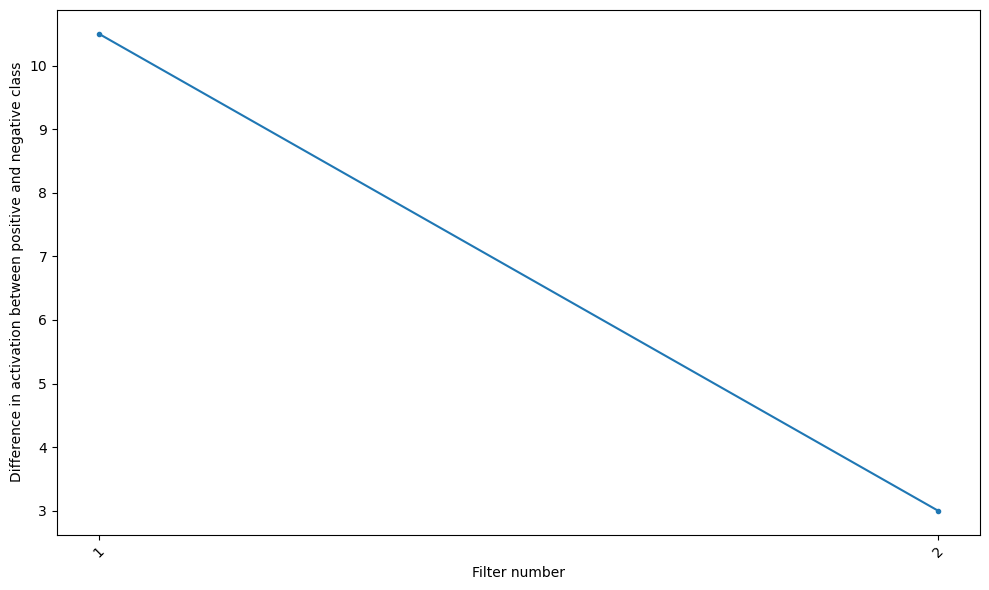

In [10]:
figures.plot_activation_difference(mean_activation_df['Filter'], mean_activation_df['Difference'])

## Activation mapping graphs for edges

* Get the patient 'graph'
* Get the filter with the strongest differentiation of maximum activation
* Do element-wise multiplication between the filter and the patient graph
* Make the edges with zero activation grey
    * Where an edge is the x and y for each timestep.
    * A node is a new node even if the node has already been visited.
    * Nodes can be named e.g. r5_t1 (read code = 5, timestep = 1)
    * Use the element-wise ('activation') result to colour the edges red if the connection isn't zero.
    
Limitations:
* This method requires there to be no overlap in the CNN windows.

In [6]:
# COULD USE THESE ARRAYS FOR THE TEST

patient_graph = input_tensors[0]
patient_graph

array([[[0, 0, 0],
        [0, 0, 3],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 4, 4]],

       [[0, 0, 0],
        [0, 2, 0],
        [0, 2, 0]],

       [[0, 0, 0],
        [5, 0, 5],
        [0, 0, 0]]])

In [7]:
max_idx = mean_activation_df['Difference'].idxmax()
max_act_filt_num = mean_activation_df.loc[max_idx, 'Filter']
max_act_filt =  filters[max_act_filt_num-1] # minus 1 as we don't have a filter called 0
max_act_filt

TypeError: reduction operation 'argmax' not allowed for this dtype

In [ ]:
# Get the activated_graph which is the graph element-wise multiplied by the sliding window

vectorized_leaky_relu = np.vectorize(calculations.leaky_relu)


# For the edge activation mapping, might need it so that the slices don't overlap otherwise there's multiple mappings
# So the stride needs to be the same size as filter.shape[0]
# This can be cheated by repeating the filter to the same size as the graph size and multiplying the two, rather than sliding

filt_num_repeats = int(patient_graph.shape[0]/max_act_filt.shape[0])
#filt_repeated = np.tile(max_act_filt, (filt_num_repeats, 1, 1))

filt_repeated = calculations.repeat_array_fractional(max_act_filt, filt_num_repeats)

# Element-wise multiplication for the patient graph and the repeated filter
filt_times_graph = filt_repeated * patient_graph

# apply a leaky relu (activation)
activated_graph = vectorized_leaky_relu(filt_times_graph)

activated_graph

In [ ]:
# Could write test to check if this would work for 4 cells being filled
# Could make fake graphs and know how we want it to look compared to the actual result

edges_df = pd.DataFrame(columns=['start_node', 'end_node', 'activated', 'weight', 'time_between'], index=range(7))

num_nodes = patient_graph.shape[1]
# get the list of the start and end nodes for each time step
timesteps = patient_graph.shape[0]

#print("time step, start_node, end_node")
row_num = 0
for t in range(timesteps):
    for i in range(num_nodes):
        for j in range(num_nodes):
            if patient_graph[t, i, j] != 0:
                if t == 0:
                    start_node_v = 0
                    end_node_v = 1
                else:
                    start_node_v = t
                    end_node_v = t+1
                
               
                #print(t, i, j)
                edges_df.at[row_num, 'end_node'] = f'{j}_v{end_node_v}' #[row num, col name]
                edges_df.at[row_num, 'weight'] = activated_graph[t, i, j]
                edges_df.at[row_num, 'time_between'] = patient_graph[t, i, j] #add a column for the edge label too (time between from original graph)
                edges_df.at[row_num, 'start_node'] = f'{i}_v{start_node_v}' #[row num, col name]
                
                row_num += 1


# activated_graph col is more than 0, the activated column = 1, otherwise it is 0
edges_df['activated'] = edges_df['weight'].apply(lambda x: 0 if x == 0 else 1)  
# change 0 weights to 0.5 so we can still see them on the graph figure
edges_df['weight'] = edges_df['weight'].apply(lambda x: 0.5 if x == 0 else x)
edges_df

In [ ]:
def extract_visit_number(s):
    return int(s.split('_')[1][1:])

pos_df = edges_df[['start_node', 'end_node']].stack().drop_duplicates().reset_index(drop=True)
pos_df = pos_df.to_frame(name='node')
pos_df['x'] = pos_df['node'].apply(extract_visit_number)
pos_df['cumulative_count'] = pos_df.groupby('x').cumcount()
pos_df['max_codes_per_visit'] = pos_df.groupby('x')['cumulative_count'].transform('max') + 1

pos_df

In [ ]:
def generate_pos_sequence(x):
    """
    Generate a list of lists to get y coordinate positions based on 
    the number of events recorded per visit.
    """
    sequence = []
    for i in range(x):
        if i % 2 == 0:  # Even index, include zero
            sequence.append(list(range(-i // 2, i // 2 + 1)))
        else:  # Odd index, exclude zero
            sublist = list(range(-(i // 2 + 1), i // 2 + 2))
            sublist.remove(0)
            sequence.append(sublist)
    return sequence


max_num_codes_per_visit = pos_df['max_codes_per_visit'].max()
pos_list = generate_pos_sequence(max_num_codes_per_visit)

# TODO: TEST - sublist for x should be...
print(pos_list)

In [ ]:
def get_pos_value(row):
    """
    Get the y position for the node. Use max_codes_per_visit to select the sublist and the 
    cumulative_count to get the position from the sublist.
    """
    cum_count = row['cumulative_count']
    max_codes = row['max_codes_per_visit']
    return pos_list[max_codes - 1][cum_count]

pos_df['y'] = pos_df.apply(get_pos_value, axis=1)

pos_df

# the visit number is x and the y value is the number of nodes with the same visit number
pos = pos_df.set_index('node')[['x', 'y']].apply(tuple, axis=1).to_dict()
pos

In [ ]:
pos_df

In [ ]:
# Convert df to list of tuples for Networkx
edges = []
for _, row in edges_df.iterrows():
    edge = (row['start_node'], row['end_node'], {'activated': row['activated'], 'weight': row['weight'], 'edge_label': row['time_between']})
    edges.append(edge)


# edges = [
#     ('1_v0', '2_v1', {'activated': 0, 'weight': 0.5, 'edge_label': 3}),
#     ('2_v1', '1_v2', {'activated': 0, 'weight': 0.5, 'edge_label': 4}),
#     ('2_v1', '2_v2', {'activated': 0, 'weight': 0.5, 'edge_label': 4}),
#     ('1_v2', '1_v3', {'activated': 1, 'weight': 2, 'edge_label': 2}),
#     ('2_v2', '1_v3', {'activated': 0, 'weight': 0.5, 'edge_label': 2}),
#     ('1_v3', '0_v4', {'activated': 0, 'weight': 0.5, 'edge_label': 5}),
#     ('1_v3', '2_v4', {'activated': 0, 'weight': 0.5, 'edge_label': 5})
# ]


G = nx.DiGraph()


G.add_edges_from(edges)


# pos = {
#     '1_v0': (0, 0),
#     '2_v1': (1, 0),
#     '1_v2': (2, 1),
#     '2_v2': (2, -1),
#     '1_v3': (3, 0),
#     '0_v4': (4, 1),
#     '2_v4': (4, -1)
# }

# Prepare edge colors and widths based on attributes
edge_colors = ['red' if G[u][v]['activated'] == 1 else 'grey' for u, v in G.edges()]
edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

# Draw the graph
plt.figure(figsize=(12, 8))

nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color=edge_colors, width=edge_widths, font_size=10, font_weight="bold", arrowsize=20)

edge_labels = {(u, v): G[u][v]['edge_label'] for u, v in G.edges()}

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10, font_weight='bold')

plt.title("Graph Visualisation of Patients Pathway and Connections Associated to Hip Replacement")
plt.show()
